 ## Importing Necessary Libraries for Data Exploration

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## About the Dataset
 This dataset focuses on predicting the recurrence of well-differentiated thyroid cancer using 13 clinicopathologic features. The data spans over 15 years, with each patient followed for at least 10 years. It originates from the UCI Machine Learning Repository and is hosted on Kaggle.

Key Features Include:

Demographics: Age, Gender

Medical History: Smoking status, History of smoking, History of radiotherapy

Clinical Info: Thyroid function, Physical exam results, Presence of adenopathy

Cancer Details: Pathology type, Focality, Risk category, Tumor (T), Node (N), Metastasis (M), Cancer Stage

Outcomes: Response to treatment, Whether the cancer recurred

This dataset provides a rich foundation for building models to assess cancer recurrence risk based on both clinical and pathological data.

## Load the Dataset

In [24]:
th = pd.read_csv(r"D:\Machine Learning\Cloned File\Thyroid-Diseases-Detection\archive\Thyroid_Diff.csv")

In [25]:
th.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


## Variable Identification

In [26]:
print("Dataset shape:", th.shape)


Dataset shape: (383, 17)


In [27]:
th.dtypes

Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

In [28]:
th.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

## Missing value Anlysis

In [29]:
print(th.isnull().sum())

Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64


## Outlier Analysis

Numerical columns: ['Age']


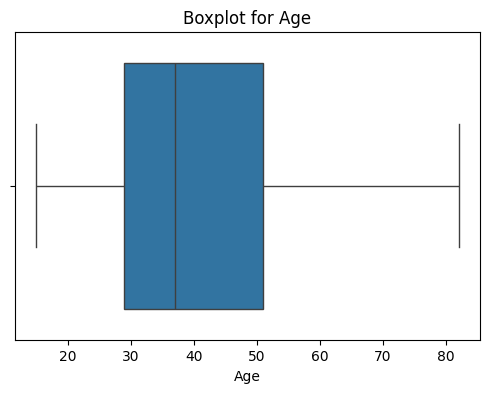

Outlier capping completed and file saved.


In [30]:
# identification numerical columns
numerical_cols = th.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", numerical_cols)

# Boxplots to visualize outliers
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=th[col])
    plt.title(f'Boxplot for {col}')
    plt.show()
    

# Capping outliers 
def cap_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] > upper_bound, upper_bound,
                 np.where(data[col] < lower_bound, lower_bound, data[col]))
    return data

for col in numerical_cols:
    th = cap_outliers(th, col)

# Save the cleaned dataset
th.to_csv('thyroid_cleaned.csv', index=False)
print("Outlier capping completed and file saved.")

